# Comparison with VIRGA using the Ackerman and Marley Cloud Model

Here, we try to compare our cloud implementation with   a cloud opacity using Ackerman and Marley Model.
We consider enstatite (MgSiO3) and Fe clouds.  


In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import virga.justdoit as jdi

In [3]:
# set common values
from exojax.utils.astrofunc import gravity_jupiter
fsed = 3.0
g = gravity_jupiter(1.0,1.0)
mu=2.2

import virga.justplotit as jpi
import astropy.units as u
fsed = 3
miedir = "/home/exoplanet01/exojax/tests/integration/comparison/clouds/.database/particulates/virga"
a = jdi.Atmosphere(["MgSiO3"], fsed = fsed, mh=1.0, mmw=mu)
a.gravity(gravity=g, gravity_unit=u.Unit('cm/(s**2)'))
a.ptk(df = jdi.hot_jupiter())
all_out = jdi.compute(a, as_dict=True, directory = miedir)

pressure = all_out["pressure"]
temperature = all_out["temperature"]

In [4]:
#kawashima
def T_MgSiO3(P,metaldex):
    return 1e4 / (6.26 - 0.35 * np.log10(P) - 0.70 * metaldex) # Visscher et al. (2010)
def T_MnS(P,metaldex):
    return 1e4 / (7.447 - 0.42 * np.log10(P) - 0.84 * metaldex) # Morley et al. (2012)




Setting a simple atmopheric model. We need the density of atmosphere.

In [5]:
from exojax.utils.constants import kB, m_u
from exojax.atm.atmprof import pressure_layer_logspace

#Parr, dParr, k = pressure_layer_logspace(log_pressure_top=-5., log_pressure_btm=4.0, nlayer=100)
#alpha = 0.097
#T0 = 1200.
#Tarr = T0 * (Parr)**alpha

mu = 2.0  # mean molecular weight
R = kB / (mu * m_u)
rho = pressure / (R * temperature)



The solar abundance can be obtained using utils.zsol.nsol. Here, we assume a maximum VMR for MgSiO3 and Fe from solar abundance. 

In [6]:
from exojax.utils.zsol import nsol

n = nsol()  #solar abundance
VMR_enstatite = np.min([n["Mg"], n["Si"], n["O"] / 3])
VMR_Fe = n["Fe"]


Vapor saturation pressures can be obtained using atm.psat

In [8]:
from exojax.atm.psat import psat_enstatite_AM01, psat_Fe_AM01

P_enstatite = psat_enstatite_AM01(temperature)
P_fe_sol = psat_Fe_AM01(temperature)


Compute a cloud base pressure.

In [9]:
from exojax.atm.amclouds import compute_cloud_base_pressure

Pbase_enstatite = compute_cloud_base_pressure(pressure, P_enstatite, VMR_enstatite)
Pbase_Fe_sol = compute_cloud_base_pressure(pressure, P_fe_sol, VMR_Fe)


In [10]:
from bokeh.io import output_notebook
from bokeh.plotting import show, figure
from bokeh.palettes import Colorblind
output_notebook()

#pressure = np.logspace(-5,3,30) #simple isotherml PT profile (kelvin)
#temperature = np.zeros(30)+1300
#temperature = T0 * (pressure)**alpha
metallicity = 1 #atmospheric metallicity relative to Solar

#get virga recommendation for which gases to run
recommended = jdi.recommend_gas(pressure, temperature, metallicity,mu,
                #Turn on plotting
                 plot=True)
#print the results
print(recommended)
#recommended = jdi.recommend_gas(Parr, Tarr, 1.0, 2.2, plot=True)

Loading BokehJS ...

['Cr', 'Mg2SiO4', 'MgSiO3', 'MnS']


The cloud base is located at the intersection of a TP profile and the vapor saturation puressure devided by VMR.

It's consistent with VIRGA and Kawashima-san's private code:


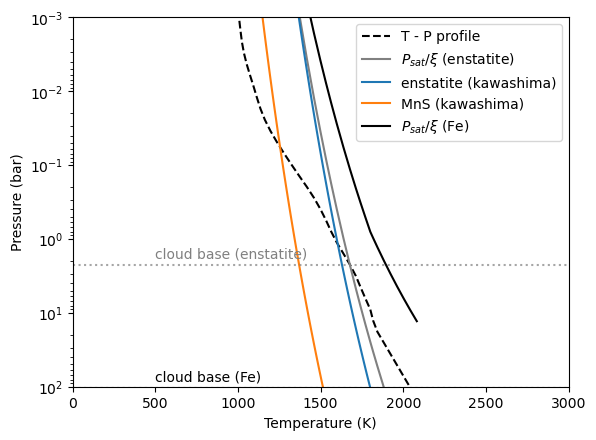

In [12]:
plt.plot(temperature, pressure, color="black", ls="dashed", label="T - P profile")
plt.plot(temperature,
         P_enstatite / VMR_enstatite,
         label="$P_{sat}/\\xi$ (enstatite)",
         color="gray")
parr=np.logspace(-3,2,100)
plt.plot(T_MgSiO3(parr,0.0),parr,label="enstatite (kawashima)")
plt.plot(T_MnS(parr,0.0),parr,label="MnS (kawashima)")

plt.axhline(Pbase_enstatite, color="gray", alpha=0.7, ls="dotted")
plt.text(500, Pbase_enstatite * 0.8, "cloud base (enstatite)", color="gray")

plt.plot(temperature, P_fe_sol / VMR_Fe, label="$P_{sat}/\\xi$ (Fe)", color="black")
plt.axhline(Pbase_Fe_sol, color="black", alpha=0.7, ls="dotted")
plt.text(500, Pbase_Fe_sol * 0.8, "cloud base (Fe)", color="black")

plt.yscale("log")
plt.ylim(1.e-3, 1.e2)
plt.xlim(0, 3000)
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel("Temperature (K)")
plt.ylabel("Pressure (bar)")
plt.savefig("pbase.pdf", bbox_inches="tight", pad_inches=0.0)
plt.savefig("pbase.png", bbox_inches="tight", pad_inches=0.0)
plt.show()

In [27]:
for key, val in all_out.items():
    print(key)

pressure
pressure_unit
temperature
temperature_unit
wave
wave_unit
condensate_mmr
cond_plus_gas_mmr
mean_particle_r
droplet_eff_r
r_units
column_density
column_density_unit
opd_per_layer
single_scattering
asymmetry
opd_by_gas
condensibles
scalar_inputs
fsed
altitude
layer_thickness
z_unit
mixing_length
mixing_length_unit
kz
kz_unit
scale_height
cloud_deck


In [28]:
con_mmr = all_out["condensate_mmr"]

Compute VMRs of clouds. Because Parr is an array, we apply jax.vmap to atm.amclouds.VMRclouds.

In [29]:
from exojax.atm.amclouds import vmr_cloud_profile

VMRbase_enstatite = VMR_enstatite
VMRc_enstatite = vmr_cloud_profile(pressure, Pbase_enstatite, fsed, VMR_enstatite)

VMRbase_Fe = VMR_Fe
VMRc_Fe = vmr_cloud_profile(pressure, Pbase_Fe_sol, fsed, VMR_Fe)


In [40]:
from exojax.spec.molinfo import molmass_isotope
molmass_enstatite = molmass_isotope("MgSiO3", db_HIT=False)
molmass_enstatite

100.3887

Here is the VMR distribution.

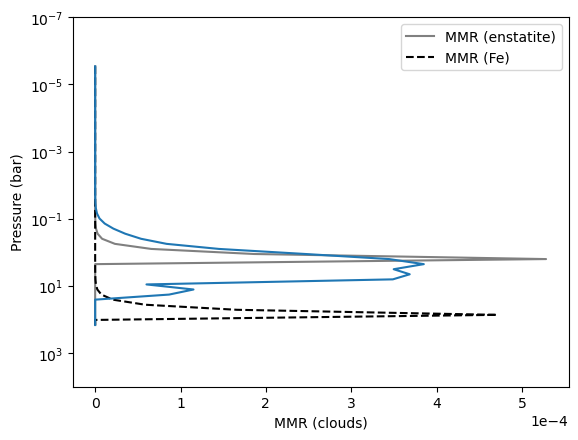

In [41]:
plt.figure()
plt.gca().get_xaxis().get_major_formatter().set_powerlimits([-3, 3])
plt.plot(VMRc_enstatite*molmass_enstatite/mu, pressure, color="gray", label="MMR (enstatite)")
plt.plot(VMRc_Fe*molmass_enstatite/mu, pressure, color="black", ls="dashed", label="MMR (Fe)")
plt.plot(con_mmr,pressure)
plt.yscale("log")
plt.ylim(1.e-7, 10000)
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel("MMR (clouds)")
plt.ylabel("Pressure (bar)")
plt.savefig("mmrcloud.pdf", bbox_inches="tight", pad_inches=0.0)
plt.savefig("mmrcloud.png", bbox_inches="tight", pad_inches=0.0)
plt.show()

Compute dynamic viscosity in H2 atmosphere (cm/g/s)

In [16]:
from exojax.atm.viscosity import eta_Rosner, calc_vfactor

T = np.logspace(np.log10(1000), np.log10(2000))
vfactor, Tr = calc_vfactor("H2")
eta = eta_Rosner(T, vfactor)


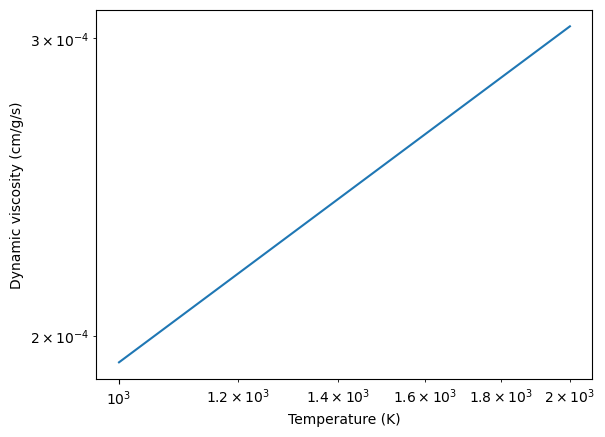

In [17]:
plt.plot(T, eta)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Temperature (K)")
plt.ylabel("Dynamic viscosity (cm/g/s)")
plt.show()

The pressure scale height can be computed using atm.atmprof.Hatm.

In [11]:
from exojax.atm.atmprof import pressure_scale_height
T = 1000  #K
mu = 2  #mean molecular weight
print("scale height=", pressure_scale_height(1.e5, T, mu), "cm")


scale height= 415722.99317937146 cm


We need a density of condensates. 

In [12]:
from exojax.atm.condensate import condensate_density, name2formula
rhoc_enstatite = condensate_density[name2formula["enstatite"]]
rhoc_Fe = condensate_density["Fe"]

from exojax.spec.molinfo import molmass

mu = molmass("H2")
muc_enstatite = molmass("MgSiO3")
muc_Fe = molmass("Fe")


['H2O', 'CO2', 'O3', 'N2O', 'CO', 'CH4', 'O2', 'NO', 'SO2', 'NO2', 'NH3', 'HNO3', 'OH', 'HF', 'HCl', 'HBr', 'HI', 'ClO', 'OCS', 'H2CO', 'HOCl', 'N2', 'HCN', 'CH3Cl', 'H2O2', 'C2H2', 'C2H6', 'PH3', 'COF2', 'SF6', 'H2S', 'HCOOH', 'HO2', 'O', 'ClONO2', 'NO+', 'HOBr', 'C2H4', 'CH3OH', 'CH3Br', 'CH3CN', 'CF4', 'C4H2', 'HC3N', 'H2', 'CS', 'SO3', 'C2N2', 'COCl2', 'SO', 'CH3F', 'GeH4', 'CS2', 'CH3I', 'NF3']
['H2O', 'CO2', 'O3', 'N2O', 'CO', 'CH4', 'O2', 'NO', 'SO2', 'NO2', 'NH3', 'HNO3', 'OH', 'HF', 'HCl', 'HBr', 'HI', 'ClO', 'OCS', 'H2CO', 'HOCl', 'N2', 'HCN', 'CH3Cl', 'H2O2', 'C2H2', 'C2H6', 'PH3', 'COF2', 'SF6', 'H2S', 'HCOOH', 'HO2', 'O', 'ClONO2', 'NO+', 'HOBr', 'C2H4', 'CH3OH', 'CH3Br', 'CH3CN', 'CF4', 'C4H2', 'HC3N', 'H2', 'CS', 'SO3', 'C2N2', 'COCl2', 'SO', 'CH3F', 'GeH4', 'CS2', 'CH3I', 'NF3']


/home/kawahara/exojax/src/exojax/spec/molinfo.py:64: UserWarning: db_HIT is set as True, but the molecular name 'MgSiO3' does not exist in the HITRAN database. So set db_HIT as False. For reference, all the available molecules in the HITRAN database are as follows:
  warnings.warn(warn_msg, UserWarning)
/home/kawahara/exojax/src/exojax/spec/molinfo.py:64: UserWarning: db_HIT is set as True, but the molecular name 'Fe' does not exist in the HITRAN database. So set db_HIT as False. For reference, all the available molecules in the HITRAN database are as follows:
  warnings.warn(warn_msg, UserWarning)


Let's compute the terminal velocity. 
We can compute the terminal velocity of cloud particle using atm.vterm.vf.
vmap is again applied to vf.

In [13]:
from exojax.atm.viscosity import calc_vfactor, eta_Rosner
from exojax.atm.vterm import terminal_velocity
from jax import vmap

vfactor, trange = calc_vfactor(atm="H2")
rarr = jnp.logspace(-6, -4, 2000)  #cm
drho = rhoc_enstatite - rho
eta_fid = eta_Rosner(Tarr, vfactor)

g = 1.e5
vf_vmap = vmap(terminal_velocity, (None, None, 0, 0, 0))
vfs = vf_vmap(rarr, g, eta_fid, drho, rho)


Kzz/L will be used to calibrate $r_w$. following Ackerman and Marley 2001  

In [14]:
Kzz = 1.e5  #cm2/s
sigmag = 2.0
alphav = 1.3
L = pressure_scale_height(g, 1500, mu)


In [15]:
Kzz/L

0.16161803517166456

Text(0.5, 0, 'condensate size (cm)')

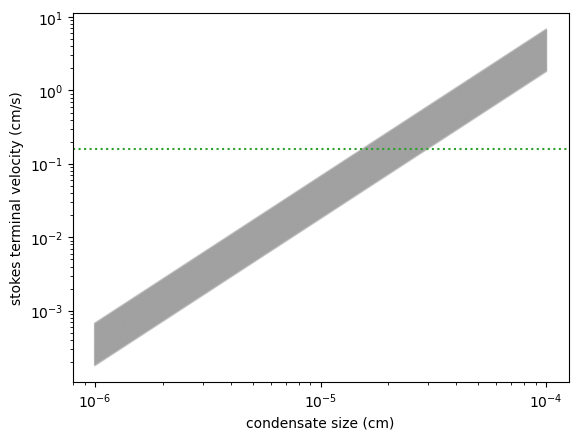

In [16]:
for i in range(0, len(Tarr)):
    plt.plot(rarr, vfs[i, :], alpha=0.2, color="gray")
plt.xscale("log")
plt.yscale("log")
plt.axhline(Kzz / L, label="Kzz/H", color="C2", ls="dotted")
plt.ylabel("stokes terminal velocity (cm/s)")
plt.xlabel("condensate size (cm)")

Find the intersection.

In [17]:
from exojax.atm.amclouds import find_rw

vfind_rw = vmap(find_rw, (None, 0, None), 0)
rw = vfind_rw(rarr, vfs, Kzz / L)


Then, $r_g$ can be computed from $r_w$ and other quantities.

In [18]:
from exojax.atm.amclouds import get_rg

rg = get_rg(rw, fsed, alphav, sigmag)


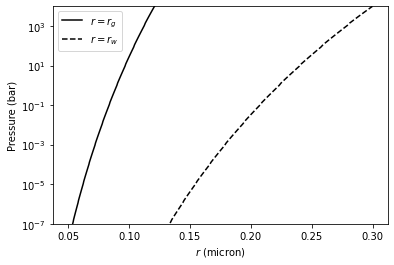

In [19]:
plt.plot(rg * 1.e4, Parr, label="$r=r_g$", color="black")
plt.plot(rw * 1.e4, Parr, ls="dashed", label="$r=r_w$", color="black")
plt.ylim(1.e-7, 10000)
plt.xlabel("$r$ (micron)")
plt.ylabel("Pressure (bar)")
plt.yscale("log")
plt.savefig("rgrw.png")
plt.legend()

We found here the particle size is basically sub-micron. So, we should use the Rayleigh scattering. 
But, here, we try to use the geometric cross section instead though this is wrong. 

In [20]:
from exojax.atm.amclouds import layer_optical_depth_cloudgeo

dtau_enstatite = layer_optical_depth_cloudgeo(Parr, muc_enstatite, rhoc_enstatite, mu,
                               VMRc_enstatite, rg, sigmag, g)
dtau_Fe = layer_optical_depth_cloudgeo(Parr, muc_Fe, rhoc_Fe, mu, VMRc_Fe, rg, sigmag, g)


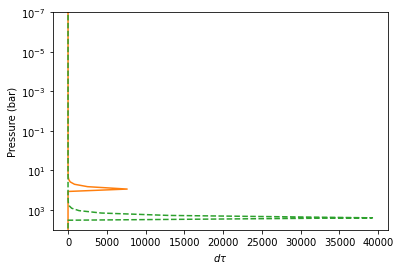

In [21]:
plt.plot(dtau_enstatite, Parr, color="C1")
plt.plot(dtau_Fe, Parr, color="C2", ls="dashed")
plt.yscale("log")
plt.ylim(1.e-7, 10000)
plt.xlabel("$d\\tau$")
plt.ylabel("Pressure (bar)")
#plt.xscale("log")
plt.gca().invert_yaxis()

Let's compare with CIA

In [22]:
#CIA
from exojax.utils.grids import wavenumber_grid

nus, wav, res = wavenumber_grid(9500, 30000, 1000, unit="AA")

from exojax.spec import contdb

cdbH2H2 = contdb.CdbCIA('.database/H2-H2_2011.cia', nus)

xsmode assumes ESLOG in wavenumber space: mode=lpf
H2-H2


/home/kawahara/exojax/src/exojax/utils/grids.py:123: UserWarning: Resolution may be too small. R=868.7669794117727
  warnings.warn('Resolution may be too small. R=' + str(resolution),


In [23]:
from exojax.spec.rtransfer import dtauCIA

mmw = 2.33  #mean molecular weight
mmrH2 = 0.74
molmassH2 = molmass("H2")
vmrH2 = (mmrH2 * mmw / molmassH2)  #VMR
dtaucH2H2=dtauCIA(nus,Tarr,Parr,dParr,vmrH2,vmrH2,\
            mmw,g,cdbH2H2.nucia,cdbH2H2.tcia,cdbH2H2.logac)

In [24]:
dtau = dtaucH2H2 + dtau_enstatite[:, None] + dtau_Fe[:, None]


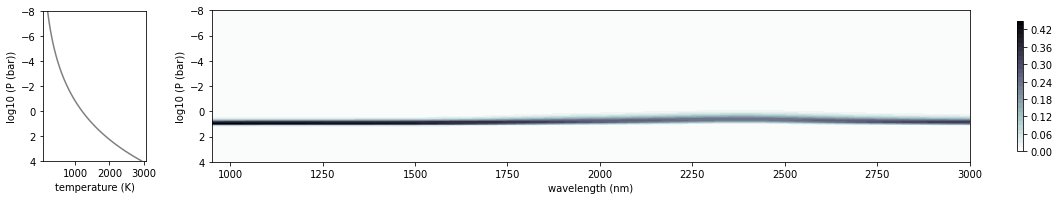

In [25]:
from exojax.plot.atmplot import plotcf

plotcf(nus, dtau, Tarr, Parr, dParr, unit="nm")
plt.show()

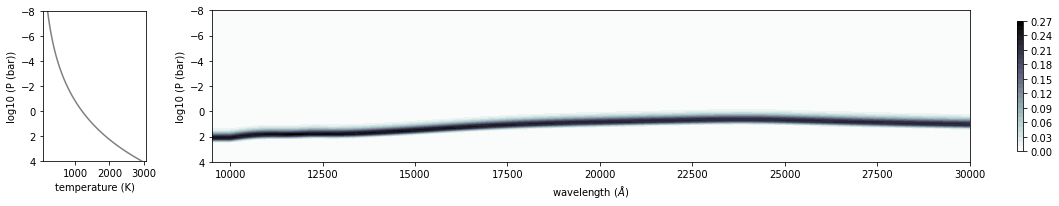

In [26]:
from exojax.plot.atmplot import plotcf

plotcf(nus, dtaucH2H2, Tarr, Parr, dParr, unit="AA")
plt.show()

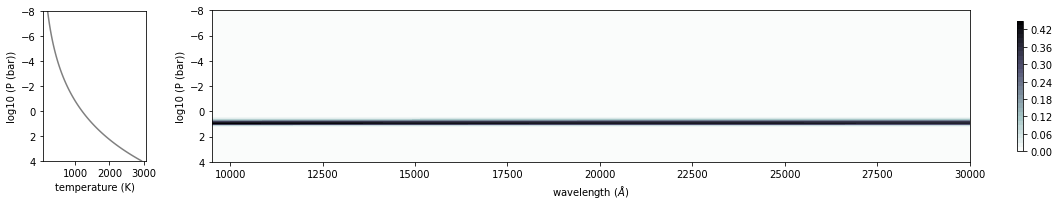

In [27]:
from exojax.plot.atmplot import plotcf

plotcf(nus,
       dtau_enstatite[:, None] + np.zeros_like(dtaucH2H2),
       Tarr,
       Parr,
       dParr,
       unit="AA")
plt.show()

In [28]:
from exojax.spec import planck
from exojax.spec.rtransfer import rtrun

sourcef = planck.piBarr(Tarr, nus)
F0 = rtrun(dtau, sourcef)
F0CIA = rtrun(dtaucH2H2, sourcef)
F0cl = rtrun(dtau_enstatite[:, None] + np.zeros_like(dtaucH2H2), sourcef)


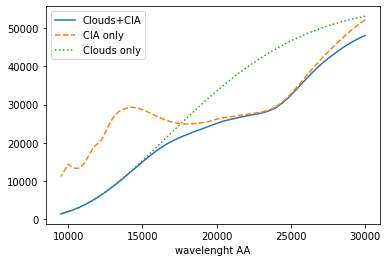

In [29]:
plt.plot(wav[::-1], F0, label="Clouds+CIA")
plt.plot(wav[::-1], F0CIA, label="CIA only", ls="dashed")
plt.plot(wav[::-1], F0cl, label="Clouds only", ls="dotted")
plt.xlabel("wavelenght AA")
plt.legend()
plt.show()